In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm


## Base class

In [193]:

class MC_Simulator_Base():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
        self.draw_dag()
        
    def simulate_data(self, a, b, c, n, sigma=10):
        """
        """
        ...

    def draw_dag(self):
        ...
    
    def save_data(self, file_path, df):
        pd.DataFrame(df).to_csv(file_path, index=False)

    
    def estimate_ols_params(self, Y, X):
        ...


    def run_mc_simulation(self, sigma=10, case='a'):
        ...
    
    def summarize_mc_simulation(self, sigma=10):
        ...
            
            

In [194]:
def fn_bias_rmse_size(theta0, thetahat, se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """

    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias, rmse, size)

## Part 1
Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases 

a. You do not control for any covariates 

b. You control for all the covariates that affect the outcome

In [195]:

class MC_Simulator_Part1(MC_Simulator_Base):
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        super().__init__(n_rep)
        
    def simulate_data(self, a, b, c, n, sigma=10):
        """
        a: intercept
        b: slope
        n: sample size
        sigma: error variance
        """
        ...
        X1 = np.random.uniform(0, 1, n)
        X2 = np.random.uniform(0, 1, n)
        e = np.random.normal(0, sigma, n)
        Y = a + b * np.log(1 + X1) + c * np.log(1 + X2) + e

        return (Y, X1, X2)

    def draw_dag(self):
        g = nx.DiGraph()
        g.add_edges_from([["X1", "Y"], ["X2", "Y"]])
        nx.draw_networkx(g)
        plt.show()

    
    def estimate_ols_params(self, Y, X):
        mod = sm.OLS(Y, X)
        res = mod.fit()
        return res


    def run_mc_simulation(self, a, b, c, n, sigma=10, case='a'):

        a_estimates = []
        b_estimates = []
        # c_estimates = []

        np.random.seed(2)
        df = pd.DataFrame()
        for idx in range(self.n_rep):
            Y, X1, X2  = self.simulate_data(a, b, c, n, sigma)
            df = df.append(pd.DataFrame({'sample_id':idx, 'Y': Y, 'X1': X1, 'X2': X2}))

            if case == 'a':
                X = sm.add_constant(X1)
            else:
                X = sm.add_constant(np.column_stack((X1, X2)))

            res = self.estimate_ols_params(Y, X)
            a_hat, b_hat = res.params[:2]
            a_estimates.append(a_hat)
            b_estimates.append(b_hat)
        
        super().save_data(f'part_1_simulated_data_case_{case}.csv', df)
        return a_estimates, b_estimates
    
    def summarize_mc_simulation(self, a, b, c, n, sigma=10, alpha=0.5):
        for case in ['a', 'b']:
            a_estimates, b_estimates = self.run_mc_simulation(a, b, c, n, sigma, case)
            (a_bias, a_rmse, a_size) = fn_bias_rmse_size(a, np.array(a_estimates), np.std(a_estimates))
            (b_bias, b_rmse, b_size) = fn_bias_rmse_size(b, np.array(b_estimates), np.std(b_estimates))

            print(f'Case {case}.: a RMSE: {np.mean(a_rmse):.3f}, bias: {np.mean(a_bias):.3f}, size: {np.mean(a_size):.3f}')
            print(f'Case {case}.: b RMSE: {np.mean(b_rmse):.3f}, bias: {np.mean(b_bias):.3f}, size: {np.mean(b_size):.3f}')
            
            

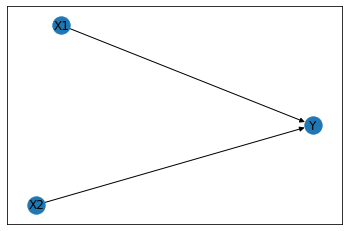

==================== sample size: 1000 ====================
Case a.: a RMSE: 1.399, bias: 1.247, size: 0.503
Case a.: b RMSE: 1.267, bias: -0.649, size: 0.094
Case b.: a RMSE: 0.864, bias: 0.211, size: 0.055
Case b.: b RMSE: 1.266, bias: -0.651, size: 0.096
==================== sample size: 100 ====================
Case a.: a RMSE: 2.433, bias: 1.272, size: 0.102
Case a.: b RMSE: 3.663, bias: -0.819, size: 0.053
Case b.: a RMSE: 2.719, bias: 0.360, size: 0.054
Case b.: b RMSE: 3.675, bias: -0.814, size: 0.051


In [196]:
MC_Sim1 = MC_Simulator_Part1(1000)

print('=' * 20 + ' sample size: 1000 ' + '=' * 20)
MC_Sim1.summarize_mc_simulation(1, 2, 3, 1000)
print('=' * 20 + ' sample size: 100 ' + '=' * 20)
MC_Sim1.summarize_mc_simulation(1, 2, 3, 100)

# X1: Husband's salary X2: Wife's salary Y: The price of their house

## Part 2
Simulate a DGP with a confounder (common cause) 

a. You fail to control for the confounder 

b. You do control for the confounder


In [197]:

class MC_Simulator_Part2(MC_Simulator_Base):
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        super().__init__(n_rep)
        
    def simulate_data(self, a1, b1, a2, b2, c, n, sigma=10):
        """
        a1: intercept X2 with respect to X1
        b1: slope X2 with respect to X1
        a2: intercept Y with respect to X1
        b2: slope Y with respect to X
        c: slop Y with respect to X2
        n: sample size
        sigma: error variance
        """
        ...
        X1 = np.random.uniform(0, 1, n)
        X2 = a1 + b1 * X1 + np.random.normal(0, sigma, n)
        Y = a2 + b2 * np.log(1 + X1) + c * X2 + np.random.normal(0, sigma, n)

        return (Y, X1, X2)

    def draw_dag(self):
        g = nx.DiGraph()
        g.add_edges_from([["X1", "X2"], ["X1", "Y"], ["X2", "Y"]])
        nx.draw_networkx(g)
        plt.show()

    
    def estimate_ols_params(self, Y, X):
        mod = sm.OLS(Y, X)
        res = mod.fit()
        return res


    def run_mc_simulation(self, a1, b1, a2, b2, c, n, sigma=10, case='a'):

        a2_estimates = []
        c_estimates = []
        # c_estimates = []

        np.random.seed(2)
        df = pd.DataFrame()
        for idx in range(self.n_rep):
            Y, X1, X2  = self.simulate_data(a1, b1, a2, b2, c, n, sigma)
            df = df.append(pd.DataFrame({'sample_id':idx, 'Y': Y, 'X1': X1, 'X2': X2}))

            if case == 'a':
                X = sm.add_constant(X2)
            else:
                X = sm.add_constant(np.column_stack((X1, X2)))

            res = self.estimate_ols_params(Y, X)
            a2_hat, c_hat = res.params[0], res.params[-1]
            a2_estimates.append(a2_hat)
            c_estimates.append(c_hat)
        
        super().save_data(f'part_2_simulated_data_case_{case}.csv', df)
        return a2_estimates, c_estimates
    
    def summarize_mc_simulation(self, a1, b1, a2, b2, c, n, sigma=10, alpha=0.5):
        for case in ['a', 'b']:
            a2_estimates, c_estimates = self.run_mc_simulation(a1, b1, a2, b2, c, n, sigma, case)
            (a2_bias, a2_rmse, a2_size) = fn_bias_rmse_size(a2, np.array(a2_estimates), np.std(a2_estimates))
            (c_bias, c_rmse, c_size) = fn_bias_rmse_size(c, np.array(c_estimates), np.std(c_estimates))

            print(f'Case {case}.: a2 RMSE: {np.mean(a2_rmse):.3f}, bias: {np.mean(a2_bias):.3f}, size: {np.mean(a2_size):.3f}')
            print(f'Case {case}.: b RMSE: {np.mean(c_rmse):.3f}, bias: {np.mean(c_bias):.3f}, size: {np.mean(c_size):.3f}')
            
            

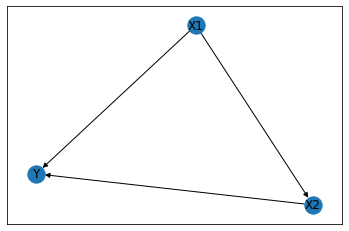

==================== sample size: 1000 ====================
Case a.: a2 RMSE: 0.819, bias: 0.759, size: 0.698
Case a.: b RMSE: 0.032, bias: 0.002, size: 0.059
Case b.: a2 RMSE: 0.626, bias: 0.087, size: 0.048
Case b.: b RMSE: 0.032, bias: 0.000, size: 0.057
==================== sample size: 100 ====================
Case a.: a2 RMSE: 1.274, bias: 0.728, size: 0.107
Case a.: b RMSE: 0.101, bias: 0.002, size: 0.052
Case b.: a2 RMSE: 1.940, bias: 0.072, size: 0.043
Case b.: b RMSE: 0.102, bias: 0.000, size: 0.048


In [198]:
MC_Sim2 = MC_Simulator_Part2(1000)

print('=' * 20 + ' sample size: 1000 ' + '=' * 20)
MC_Sim2.summarize_mc_simulation(1, 2, 1, 2, 3, 1000)
print('=' * 20 + ' sample size: 100 ' + '=' * 20)
MC_Sim2.summarize_mc_simulation(1, 2, 1, 2, 3, 100)

# X1: Age, X2: Brain activities Y: SD

## Part 3 
Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome) 

a. You control for the variable in between the path from cause to effect 

b. You do not control for the variable in between the path from cause to effect

In [199]:

class MC_Simulator_Part3(MC_Simulator_Base):
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        super().__init__(n_rep)
        
    def simulate_data(self, a, b, c, n, sigma=10):
        """
        a: intercept
        b: slope1
        c: slope2
        n: sample size
        sigma: error variance
        """
        ...
        X1 = np.random.uniform(0, 1, n)
        X2 = np.random.uniform(0, 1, n)
        e = np.random.normal(0, sigma, n)
        Y = a + b * np.log(1 + X1) + c * np.log(1 + X2) + e

        return (Y, X1, X2)

    def draw_dag(self):
        g = nx.DiGraph()
        g.add_edges_from([["X1", "Y"], ["X2", "Y"]])
        nx.draw_networkx(g)
        plt.show()

    
    def estimate_ols_params(self, Y, X):
        mod = sm.OLS(Y, X)
        res = mod.fit()
        return res


    def run_mc_simulation(self, a, b, c, n, sigma=10, case='a'):

        a_estimates = []
        b_estimates = []
        c_estimates = []
        # c_estimates = []

        np.random.seed(2)
        df = pd.DataFrame()
        for idx in range(self.n_rep):
            Y, X1, X2  = self.simulate_data(a, b, c, n, sigma)
            df = df.append(pd.DataFrame({'sample_id':idx, 'Y': Y, 'X1': X1, 'X2': X2}))
            X = np.column_stack([X1, X2])
            if case == 'a':
                X = sm.add_constant(X[:n//2])
                Y = Y[:n//2]
            else:
                X = sm.add_constant(X)

            res = self.estimate_ols_params(Y, X)
            a_hat, b_hat, c_hat = res.params
            a_estimates.append(a_hat)
            b_estimates.append(b_hat)
            c_estimates.append(c_hat)
        
        super().save_data(f'part_3_simulated_data_case_{case}.csv', df)
        return a_estimates, b_estimates, c_estimates
    
    def summarize_mc_simulation(self, a, b, c, n, sigma=10, alpha=0.5):
        for case in ['a', 'b']:
            a_estimates, b_estimates, c_estimates = self.run_mc_simulation(a, b, c, n, sigma, case)
            (a_bias, a_rmse, a_size) = fn_bias_rmse_size(a, np.array(a_estimates), np.std(a_estimates))
            (b_bias, b_rmse, b_size) = fn_bias_rmse_size(b, np.array(b_estimates), np.std(b_estimates))
            (c_bias, c_rmse, c_size) = fn_bias_rmse_size(c, np.array(c_estimates), np.std(c_estimates))

            print(f'Case {case}.: a RMSE: {np.mean(a_rmse):.3f}, bias: {np.mean(a_bias):.3f}, size: {np.mean(a_size):.3f}')
            print(f'Case {case}.: b RMSE: {np.mean(b_rmse):.3f}, bias: {np.mean(b_bias):.3f}, size: {np.mean(b_size):.3f}')
            print(f'Case {case}.: c RMSE: {np.mean(c_rmse):.3f}, bias: {np.mean(c_bias):.3f}, size: {np.mean(c_size):.3f}')
            

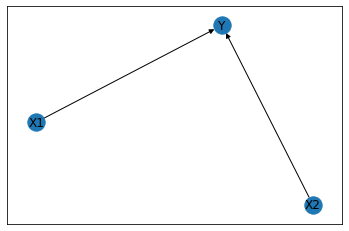

==================== sample size: 1000 ====================
Case a.: a RMSE: 1.260, bias: 0.241, size: 0.052
Case a.: b RMSE: 1.697, bias: -0.680, size: 0.073
Case a.: c RMSE: 1.812, bias: -0.934, size: 0.088
Case b.: a RMSE: 0.864, bias: 0.211, size: 0.055
Case b.: b RMSE: 1.266, bias: -0.651, size: 0.096
Case b.: c RMSE: 1.444, bias: -0.926, size: 0.131
==================== sample size: 100 ====================
Case a.: a RMSE: 3.955, bias: 0.181, size: 0.051
Case a.: b RMSE: 5.350, bias: -0.689, size: 0.058
Case a.: c RMSE: 5.178, bias: -1.048, size: 0.063
Case b.: a RMSE: 2.719, bias: 0.360, size: 0.054
Case b.: b RMSE: 3.675, bias: -0.814, size: 0.051
Case b.: c RMSE: 3.605, bias: -1.181, size: 0.055


In [200]:
MC_Sim3 = MC_Simulator_Part3(1000)

print('=' * 20 + ' sample size: 1000 ' + '=' * 20)
MC_Sim3.summarize_mc_simulation(1, 2, 3, 1000)
print('=' * 20 + ' sample size: 100 ' + '=' * 20)
MC_Sim3.summarize_mc_simulation(1, 2, 3, 100)

# X1: Whether, X2: Temperature, Y: Air humidity, The samples are from rainy days.

## Part 4 
Simulate a DGP where the outcome variable is overrepresented at 0. 

a. You estimate the treatment effect parameter using the Conditional-on-Positives (COP) framework 

b. You estimate the treatment effect using the conventional method of comparing the outcomes of treated and untreated individuals.